<a href="https://colab.research.google.com/github/dulshan97/Dino-Game/blob/main/speakerD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pickle
import warnings
import librosa
import numpy as np
import pandas as pd
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.mixture import *
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
segLen,frameRate,numMix = 3,50,128

In [ ]:
def VoiceActivityDetection(wavData, frameRate):
    # uses the librosa library to compute short-term energy
    ste = librosa.feature.rms(wavData,hop_length=int(16000/frameRate)).T
    thresh = 0.1*(np.percentile(ste,97.5) + 9*np.percentile(ste,2.5))    # Trim 5% off and set threshold as 0.1x of the ste range
    return (ste>thresh).astype('bool')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/audiofile"
# audio file path
wavFile = "/content/drive/MyDrive/audiofile/6313.wav"

Mounted at /content/drive
/content/drive/My Drive/audiofile


In [ ]:
wavData,_ = librosa.load(wavFile,sr=16000)
%time vad=VoiceActivityDetection(wavData,frameRate)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


CPU times: user 123 ms, sys: 39.5 ms, total: 163 ms
Wall time: 174 ms


In [ ]:
mfcc = librosa.feature.mfcc(wavData, sr=16000, n_mfcc=20,hop_length=int(16000/frameRate)).T
vad = np.reshape(vad,(len(vad),))
if mfcc.shape[0] > vad.shape[0]:
    vad = np.hstack((vad,np.zeros(mfcc.shape[0] - vad.shape[0]).astype('bool'))).astype('bool')
elif mfcc.shape[0] < vad.shape[0]:
    vad = vad[:mfcc.shape[0]]
mfcc = mfcc[vad,:];

In [ ]:
n_components = np.arange(1,25)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(mfcc)
          for n in n_components]

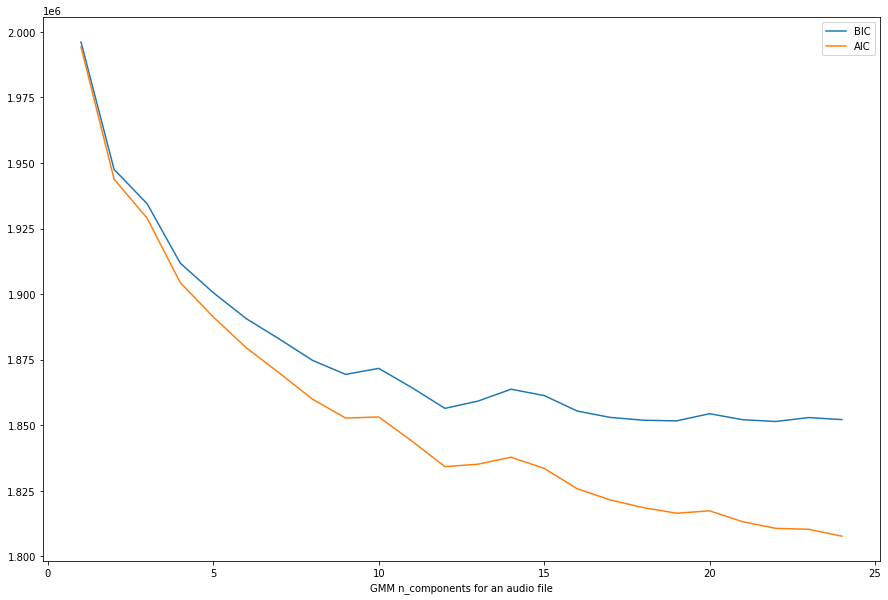

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(n_components, [m.bic(mfcc) for m in models], label='BIC')
plt.plot(n_components, [m.aic(mfcc) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('GMM n_components for an audio file');

In [ ]:
def trainGMM(wavFile, frameRate, segLen, vad, numMix):
    wavData,_ = librosa.load(wavFile,sr=16000)
    mfcc = librosa.feature.mfcc(wavData, sr=16000, n_mfcc=20,hop_length=int(16000/frameRate)).T
    vad = np.reshape(vad,(len(vad),))
    if mfcc.shape[0] > vad.shape[0]:
        vad = np.hstack((vad,np.zeros(mfcc.shape[0] - vad.shape[0]).astype('bool'))).astype('bool')
    elif mfcc.shape[0] < vad.shape[0]:
        vad = vad[:mfcc.shape[0]]
    mfcc = mfcc[vad,:];
    print("Training GMM..")
    GMM = GaussianMixture(n_components=numMix,covariance_type='diag').fit(mfcc)
    var_floor = 1e-5
    segLikes = []
    segSize = frameRate*segLen
    for segI in range(int(np.ceil(float(mfcc.shape[0])/(frameRate*segLen)))):
        startI = segI*segSize
        endI = (segI+1)*segSize
        if endI > mfcc.shape[0]:
            endI = mfcc.shape[0]-1
        if endI==startI:    
            break
        seg = mfcc[startI:endI,:]
        compLikes = np.sum(GMM.predict_proba(seg),0)
        segLikes.append(compLikes/seg.shape[0])
    print("Training Done")

    return np.asarray(segLikes)

In [ ]:
clusterset = trainGMM(wavFile, frameRate, segLen, vad, numMix)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Training GMM..
Training Done


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(clusterset)  
# Normalizing the data 
X_normalized = normalize(X_scaled)

cluster = SpectralClustering(n_clusters=2) 
clust=cluster.fit_predict(X_normalized)

In [ ]:
def SegmentFrame(clust, segLen, frameRate, numFrames):
    frameClust = np.zeros(numFrames)
    for clustI in range(len(clust)-1):
        frameClust[clustI*segLen*frameRate:(clustI+1)*segLen*frameRate] = clust[clustI]*np.ones(segLen*frameRate)
    frameClust[(clustI+1)*segLen*frameRate:] = clust[clustI+1]*np.ones(numFrames-(clustI+1)*segLen*frameRate)
    return frameClust

In [ ]:
frameClust = SegmentFrame(clust, segLen, frameRate, mfcc.shape[0])

In [ ]:
def speakerdiarisationdf(hyp, frameRate, wavFile):
    audioname=[]
    starttime=[]
    endtime=[]
    speakerlabel=[]
            
    spkrChangePoints = np.where(hyp[:-1] != hyp[1:])[0]
    if spkrChangePoints[0]!=0 and hyp[0]!=-1:
        spkrChangePoints = np.concatenate(([0],spkrChangePoints))
    spkrLabels = []    
    for spkrHomoSegI in range(len(spkrChangePoints)):
        spkrLabels.append(hyp[spkrChangePoints[spkrHomoSegI]+1])
    for spkrI,spkr in enumerate(spkrLabels[:-1]):
        if spkr!=-1:
            audioname.append(wavFile.split('/')[-1].split('.')[0]+".wav")
            starttime.append((spkrChangePoints[spkrI]+1)/float(frameRate))
            endtime.append((spkrChangePoints[spkrI+1]-spkrChangePoints[spkrI])/float(frameRate))
            speakerlabel.append("Speaker "+str(int(spkr)))
    if spkrLabels[-1]!=-1:
        audioname.append(wavFile.split('/')[-1].split('.')[0]+".wav")
        starttime.append(spkrChangePoints[-1]/float(frameRate))
        endtime.append((len(hyp) - spkrChangePoints[-1])/float(frameRate))
        speakerlabel.append("Speaker "+str(int(spkrLabels[-1])))
    #
    speakerdf=pd.DataFrame({"Audio":audioname,"starttime":starttime,"endtime":endtime,"speakerlabel":speakerlabel})
    
    spdatafinal=pd.DataFrame(columns=['Audio','SpeakerLabel','StartTime','EndTime'])
    i=0
    k=0
    j=0
    spfind=""
    stime=""
    etime=""
    for row in speakerdf.itertuples():
        if(i==0):
            spfind=row.speakerlabel
            stime=row.starttime
        else:
            if(spfind==row.speakerlabel):
                etime=row.starttime        
            else:
                spdatafinal.loc[k]=[wavFile.split('/')[-1].split('.')[0]+".wav",spfind,stime,row.starttime]
                k=k+1
                spfind=row.speakerlabel
                stime=row.starttime
        i=i+1
    spdatafinal.loc[k]=[wavFile.split('/')[-1].split('.')[0]+".wav",spfind,stime,etime]
    return spdatafinal

In [ ]:
pass1hyp = -1*np.ones(len(vad))
pass1hyp[vad] = frameClust
spkdf=speakerdiarisationdf(pass1hyp, frameRate, wavFile)

spkdf["TimeSeconds"]=spkdf.EndTime-spkdf.StartTime

spkdf

,Audio,SpeakerLabel,StartTime,EndTime,TimeSeconds
0,6313.wav,Speaker 1,1.50,8.28,6.78
1,6313.wav,Speaker 0,8.28,156.88,148.60
2,6313.wav,Speaker 1,156.88,165.66,8.78
3,6313.wav,Speaker 0,165.66,216.84,51.18
4,6313.wav,Speaker 1,216.84,221.32,4.48
5,6313.wav,Speaker 0,221.32,236.98,15.66
6,6313.wav,Speaker 1,236.98,241.22,4.24
7,6313.wav,Speaker 0,241.22,310.68,69.46
8,6313.wav,Speaker 1,310.68,315.20,4.52
9,6313.wav,Speaker 0,315.20,393.58,78.38


In [ ]:
time = spkdf.at[1,'StartTime']
print(type(spkdf))
list = spkdf.values.tolist()

print(list[0])
val = list[0]
print(type(val[4]))

<class 'pandas.core.frame.DataFrame'>
['6313.wav', 'Speaker 1', 1.5, 8.28, 6.779999999999999]
<class 'float'>


In [ ]:
!pip install ffmpeg-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import ffmpeg

In [ ]:
for p in range(len(list)):
    y = list[p]
    speker = y[1]
    start_time = y[2]
    duration = round(y[4], 2)
    audio_input = ffmpeg.input(wavFile)
    audio_cut = audio_input.audio.filter('atrim', start=start_time, duration=duration)
    audio_output = ffmpeg.output(audio_cut, '/content/drive/MyDrive/audiofile/split/out'+str(p)+'.wav')
    ffmpeg.run(audio_output)
    

In [ ]:
!pip3 install SpeechRecognition pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 32.8 MB 1.3 MB/s 


In [ ]:
import speech_recognition as sr
import librosa

In [ ]:
s_duration1 = 0
s_duration2 = 0
for p in range(len(list)):
    y = list[p]
    speker = y[1]
    start_time = y[2]
    duration = round(y[4], 2)
    if(p%2 == 1):
      # print(y[4])
      s_duration1 = s_duration1 + y[4]
    else:
      # print(y[4])
      s_duration2 = s_duration2 + y[4]


print(s_duration1)
print(s_duration2)


if(s_duration2>s_duration1):
  x = 0
  for i in range(len(list)):
    filename = "/content/drive/MyDrive/audiofile/split/out"+str(x)+".wav"
    x = x + 2
    r = sr.Recognizer()
    try:
      with sr.AudioFile(filename) as source:
        audio_data = r.record(source)
    # recognize (convert from speech to text)
        text = r.recognize_google(audio_data)

        item = list[i]
        speker = item[1]
        print(text)
    except:
       print("")
else:
  x = 1
  for i in range(len(list)):
    filename = "/content/drive/MyDrive/audiofile/split/out"+str(x)+".wav"
    x = x + 2
    r = sr.Recognizer()
    try:
      with sr.AudioFile(filename) as source:
        audio_data = r.record(source)
    # recognize (convert from speech to text)
        text = r.recognize_google(audio_data)

        item = list[i]
        speker = item[1]
        print(text)
    
    except:
       print("")

447.78000000000003
154.07999999999996
basically it's an intensive program designed to last four weeks four weeks on although we do have two sessions in 1996 that will be two weeks 4 weeks 7 hours of contact you today Spanish it involves starting at 9 in the morning or 3 hours is grammar instruction and then it's followed immediately by an hour group conversation with the same instructor same class but we have extensive Gardens Hearing Institute and so students. Usually go out to a garden settings because it's a bit more comfortable after a break for lunch of instruction in that instead of textbook and clinical pipe construction we have hands on and we have we offer workshops in May backdrop leading Regional cooking of Oaxaca and if you have large groups we also also offer and those are two hours a day Monday through Thursday really in place not too much could teach you to dance with crown but they're in place to facilitate Spanish language acquisition with a Hands-On project is our bel

In [ ]:
!pip3 install SpeechRecognition pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import speech_recognition as sr
import librosa

In [ ]:
for i in range(len(list)):
  filename = "/content/drive/MyDrive/audiofile/split/out"+str(i)+".wav"
  r = sr.Recognizer()
  try:
   with sr.AudioFile(filename) as source:
    # listen for the data (load audio to memory)
    audio_data = r.record(source)
    # recognize (convert from speech to text)
    text = r.recognize_google(audio_data)

    item = list[i]
    speker = item[1]
    print(speker +" : "+ text)
  except:
    print("")


Speaker 1 : okay I was wondering if you could tell me a little bit about the program what exactly goes on and okay
Speaker 0 : basically it's an intensive program designed to last four weeks four weeks on although we do have two sessions in 1996 that will be two weeks 4 weeks 7 hours of contact you today Spanish it involves starting at 9 in the morning or 3 hours is grammar instruction and then it's followed immediately by an hour group conversation with the same instructor same class but we have extensive Gardens Hearing Institute and so students. Usually go out to a garden settings because it's a bit more comfortable after a break for lunch of instruction in that instead of textbook and clinical pipe construction we have hands on and we have we offer workshops in May backdrop leading Regional cooking of Oaxaca and if you have large groups we also also offer and those are two hours a day Monday through Thursday really in place not too much could teach you to dance with crown but they'